In [1]:
## jupyter notebook to simulate the range of the nuclear recoils in a given decay chain

import numpy as np
import matplotlib.pyplot as plt
import alpha_recoil_sim as ar
import importlib

In [2]:
## make dictionary containing decay chain information for a given list of isotopes
path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC"

iso_list = ['Ac-225', 'Pb-212', 'At-211', 'Th-227', 'Ra-223']

iso_dict = {}

for iso in iso_list:
    ciso = iso[:2].lower()
    cA = iso[-3:]
    iso_dict[iso] = ar.parse_decay_chain(path + "/decay_data/" + ciso + "_" + cA + "_decay_chain.txt")

{'Ac-225': {'Ac-225_t12': 864000.0, 'Ac-225_decays': array([[5.070e-01, 5.830e+03],
       [1.810e-01, 5.793e+03],
       [8.600e-02, 5.791e+03],
       [9.300e-02, 5.732e+03],
       [3.100e-02, 5.724e+03],
       [1.020e-01, 5.637e+03]]), 'Ac-225_daughters': ['Fr-221', 'Fr-221', 'Fr-221', 'Fr-221', 'Fr-221', 'Fr-221'], 'Fr-221_t12': 286.1, 'Fr-221_decays': array([[8.330e-01, 6.341e+03],
       [1.400e-02, 6.242e+03],
       [1.530e-01, 6.126e+03]]), 'Fr-221_daughters': ['At-217', 'At-217', 'At-217'], 'At-217_t12': 0.0323, 'At-217_decays': array([[1.000e+00, 7.067e+03]]), 'At-217_daughters': ['Bi-213'], 'Bi-213_t12': 2736.0, 'Bi-213_decays': array([[1.959e-02, 5.875e+03],
       [1.810e-03, 5.558e+03],
       [9.786e-01, 0.000e+00]]), 'Bi-213_daughters': ['Tl-209', 'Tl-209', 'Po-213'], 'Tl-209_t12': 129.60000000000002, 'Tl-209_decays': array([[1., 0.]]), 'Tl-209_daughters': ['Pb-209'], 'Po-213_t12': 3.7e-06, 'Po-213_decays': array([[1.000e+00, 8.376e+03]]), 'Po-213_daughters': ['Pb-20

0.49917


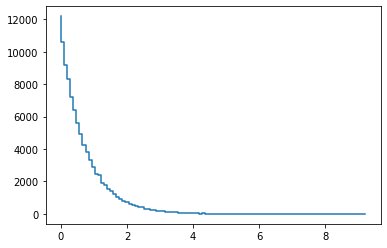

In [9]:
importlib.reload(ar)

nmc = 100000
t = []
for n in range(nmc):
    t.append(ar.get_random_decay_time(0.5))
t = np.array(t)

h, be = np.histogram(t, bins =100)

plt.figure()
plt.step(be[:-1], h, where='pre')

print(np.sum( t <= 0.5)/len(t))

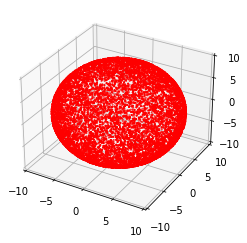

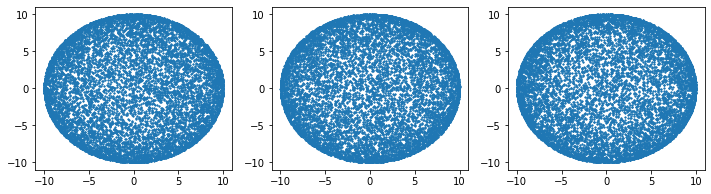

In [4]:
importlib.reload(ar)


points_x = np.linspace(10,10, 2)
points_y = np.zeros_like(points_x)
points_z = np.zeros_like(points_x)

points = np.vstack((points_x, points_y, points_z)).T

nmc = 10000

for i in range(nmc):
    random_angles = ar.random_angle_on_sphere()

    rp = ar.rotate_3d_data(points, random_angles)

    if(i==0):
        rotated_points = rp
    else:
        rotated_points = np.vstack((rotated_points, rp))
#or idx in range(len(points[:,0])):
#   rotated_points[idx, :] = ar.rotate_3d_data(points[idx, :], )

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot the scatter plot with x, y, and z values
ax.scatter(points[:,0], points[:,1], points[:,2], s=1, c='k')
ax.scatter(rotated_points[:,0], rotated_points[:,1], rotated_points[:,2], s=1, c='r')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

def update(frame):
    # Rotate the sphere by a small angle
    ax.view_init(30, frame * 2)

# Set up the animation
#ani = animation.FuncAnimation(fig, update, frames=180, interval=50, blit=False)

#plt.show()

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.scatter(rotated_points[:,0], rotated_points[:,1], s=1)

plt.subplot(1,3,2)
plt.scatter(rotated_points[:,0], rotated_points[:,2], s=1)

plt.subplot(1,3,3)
plt.scatter(rotated_points[:,1], rotated_points[:,2], s=1)

plt.show()

In [193]:
import pickle

data_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/SRIM_Data/'

with open(data_path + 'SRIM_MC_events.pkl', 'rb') as f:
    MC_dict = pickle.load(f)

In [311]:
importlib.reload(ar)


sphere_dict = {"inner_radius": 20, "outer_shell_thick": 100, "inner_material": "SiO2", "shell_material": "Ag"}

out = ar.sim_N_events(1000, "Ac-225", iso_dict, sphere_dict, MC_dict)

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC/alpha_recoil_sim.py:206: RuntimeWarning: invalid value encountered in double_scalars
  ct = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC/alpha_recoil_sim.py:211: RuntimeWarning: invalid value encountered in true_divide
  u = u / np.linalg.norm(u)   # normalize the axis vector


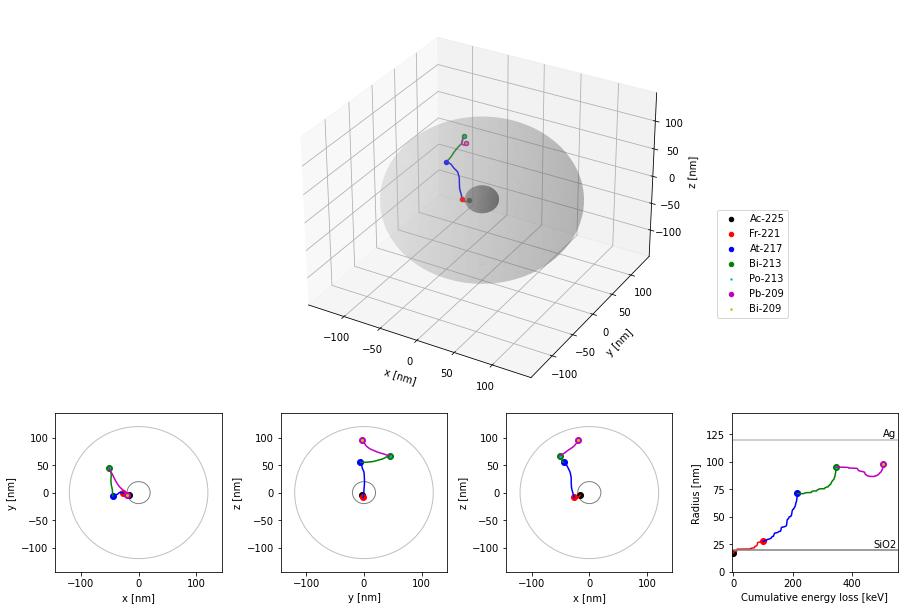

In [321]:
importlib.reload(ar)
ar.plot_event(out[99], sphere_dict)

In [154]:
importlib.reload(ar)

vec2 = [0,1,0] ## new direction
vec1 = [1,0,0] ## initial direction
R = ar.get_euler_for_two_traj(vec2, vec1)
print(R)
d = np.array([vec1,vec2])
print(d)
ar.rotate_3d_data(d, [], R)

theta:  1.5707963267948966
axis:  [0. 0. 1.]
[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]
[[1 0 0]
 [0 1 0]]


array([[ 0.,  1.,  0.],
       [-1.,  0.,  0.]])

In [174]:
## double check the traj files

MC_dict.keys()

dict_keys(['Fr-221_SiO2', 'At-217_SiO2', 'Bi-213_SiO2', 'Tl-209_SiO2', 'Pb-209_SiO2', 'Tl-208_SiO2', 'Pb-208_SiO2', 'Bi-207_SiO2', 'Pb-207_SiO2', 'Ra-223_SiO2', 'Rn-219_SiO2', 'Po-215_SiO2', 'Pb-211_SiO2', 'Tl-207_SiO2', 'Fr-221_Au', 'At-217_Au', 'Bi-213_Au', 'Tl-209_Au', 'Pb-209_Au', 'Tl-208_Au', 'Pb-208_Au', 'Bi-207_Au', 'Pb-207_Au', 'Ra-223_Au', 'Rn-219_Au', 'Po-215_Au', 'Pb-211_Au', 'Tl-207_Au', 'Fr-221_Ag', 'At-217_Ag', 'Bi-213_Ag', 'Tl-209_Ag', 'Pb-209_Ag', 'Tl-208_Ag', 'Pb-208_Ag', 'Bi-207_Ag', 'Pb-207_Ag', 'Ra-223_Ag', 'Rn-219_Ag', 'Po-215_Ag', 'Pb-211_Ag', 'Tl-207_Ag'])

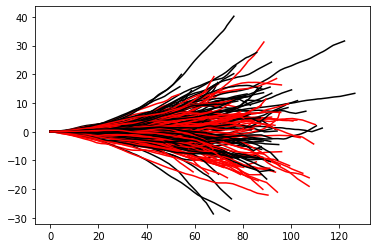

In [182]:
plt.figure(facecolor='white')

for i in range(1,100):
    
    cdat = MC_dict['Fr-221_SiO2']
    plt.plot(cdat[i][:,1], cdat[i][:,2], 'k')

    cdat = MC_dict['Fr-221_Au']
    plt.plot(cdat[i][:,1], cdat[i][:,2], 'r')
